# Random Forest Classifier

In [135]:
%load_ext IPython.extensions.autoreload
%autoreload 2

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [136]:
import sys,os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [137]:
import numpy as np
from src.data_reader import DataSource, read_vertices_VTK, num_vertices_VTK
from src.descriptors.dscs_driver import compute_descriptors

from src.utils import get_free_id, write_jsonl, clear_jsonl

!pip install numpy==1.23.0

In [138]:
from ripser import ripser
from persim import plot_diagrams

In [139]:
from gudhi import RipsComplex, AlphaComplex, plot_persistence_diagram
from gudhi.representations import ProminentPoints
from gudhi.representations import PersistenceImage

In [140]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier

import joblib

In [141]:
import csv

### Reload descriptors

In [19]:
# load descriptors

Model='quantiles'
Model = 'AlphaProminent'

# data base path
data_base = './data/data/'

save_descs_path = os.path.join(data_base,'saved_descriptors/train_set/')

#data = np.load(os.path.join(save_descs_path,Model+'Data.npy'))
data = np.load(os.path.join(save_descs_path,'EncodedAlphaProminent.npy'))
#labels = np.load(os.path.join(save_descs_path,Model+'Labels.npy'))

print(data.shape, labels.shape)

(9244, 15) (9244,)


#### Sectors Data + Alpha - NOT augmented

In [152]:
dataS = np.load( './data/sectors/saved_descriptors/train_set/TrainData.npy' )
dataAlpha = np.load('./data/data/saved_descriptors/train_set/AlphaProminent.npy')

data = np.concatenate( [dataS , dataAlpha] , axis = 1 )
data = dataAlpha

In [153]:
data.shape

(9244, 75)

In [154]:
labels = np.load('./data/data/saved_descriptors/train_set/AlphaProminentLabels.npy')

In [155]:
labels.shape

(9244,)

# Cross-Validation

In [156]:
StrShSp = StratifiedShuffleSplit(n_splits=15, train_size=0.8, random_state=42)

# get indices of split
train_idx, val_idx = next(StrShSp.split(data, labels))

train_data = data[train_idx,:]
train_labels = labels[train_idx]

val_data = data[val_idx]
val_labels = labels[val_idx]

# log file for run
run_log = './runs/trainings/runs.jsonl'
# get a new run id
run_id = get_free_id(run_log)


In [157]:
train_idx.shape

(7395,)

<BarContainer object of 100 artists>

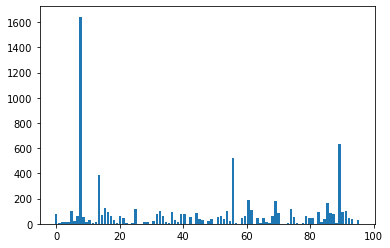

In [158]:
counts, bins = np.histogram(train_labels, bins=100)
plt.bar(bins[:-1],counts)

<BarContainer object of 100 artists>

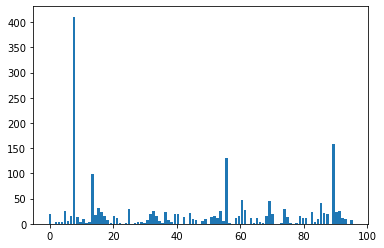

In [159]:
counts, bins = np.histogram(val_labels, bins=100)
plt.bar(bins[:-1],counts)

In [160]:
_, counts = np.unique(labels,return_counts=True)
np.sort(counts)

array([   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    3,
          3,    3,    3,    5,    5,    6,    7,    8,    9,   10,   10,
         10,   10,   10,   14,   14,   15,   17,   17,   18,   18,   19,
         21,   22,   23,   25,   26,   27,   33,   34,   35,   37,   42,
         43,   44,   49,   49,   52,   53,   54,   54,   57,   57,   58,
         58,   61,   66,   69,   70,   71,   73,   73,   74,   75,   76,
         76,   78,   80,   89,   93,   95,   95,   97,  101,  102,  103,
        109,  115,  116,  118,  119,  126,  127,  128,  129,  135,  143,
        150,  154,  203,  223,  240,  489,  654,  788, 2054])

In [161]:
np.unique(val_labels).shape

(85,)

# Classifier

#### Random forest

In [37]:
data = np.load('ThisData.npy')
labels.shape

(9244,)

In [162]:
# Random Forest

N_Estimators = 150
criterion = 'entropy'

forest = RandomForestClassifier(n_estimators=N_Estimators, criterion=criterion, max_features='sqrt', max_depth=None)
forest.fit(train_data, train_labels)

params = {'id':run_id , 'model':'RF' , 'n_estimators':N_Estimators , 'criterion':criterion}

# SAVE Model
trained_model_path = './trained_models/random_forest/'

joblib.dump(forest , os.path.join(trained_model_path, 'model.pkl'));

In [163]:
pred_labels = forest.predict(val_data)
#pred_labels = forest.predict(data)

# Scoring

In [164]:
acc = accuracy_score(val_labels, pred_labels)
#acc = accuracy_score(labels, pred_labels)

params.update( {'accuracy':acc} )
write_jsonl(run_log, params)
print(acc)

0.7766360194699837


In [165]:
print(classification_report(val_labels, pred_labels, zero_division=0.0))
#print(classification_report(labels, pred_labels, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           2       1.00      1.00      1.00         3
           3       1.00      0.50      0.67         4
           4       0.00      0.00      0.00         3
           5       0.90      0.76      0.83        25
           6       1.00      0.20      0.33         5
           7       0.86      0.80      0.83        15
           8       0.89      1.00      0.94       411
           9       0.79      0.85      0.81        13
          10       1.00      0.67      0.80         3
          11       1.00      0.22      0.36         9
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         4
          14       0.58      0.90      0.70        98
          15       0.88      0.83      0.86        18
          16       0.77      0.77      0.77        31
          17       0.80      0.87      0.83        23
          18       0.85    

In [166]:
np.unique(pred_labels).shape

(70,)

In [167]:
np.unique(val_labels).shape

(85,)

In [171]:
TestDataAlpha = np.load('./data/data/saved_descriptors/test_set/AlphaProminentData.npy')
TestDataS = np.load('./data/sectors/saved_descriptors/test_set/TestSectorData.npy')

In [172]:
TestData = np.concatenate( [TestDataAlpha , TestDataS] , axis = 1 )
TestData = TestDataAlpha

In [173]:
pred_labels = forest.predict(TestData)

### Plot

In [174]:
hist, bins = np.histogram(pred_labels, bins=np.arange(0,97), density=True)
histTruth, _ = np.histogram(labels, bins=np.arange(0,97), density=True)

<BarContainer object of 96 artists>

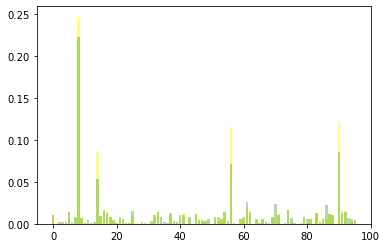

In [175]:
plt.bar(bins[:-1],hist, alpha=0.5, color='yellow', label='Pred')
plt.bar(bins[:-1],histTruth, alpha=0.3, color='green', label='True')

### Try clean alpha prominent alone

In [117]:
data_aug = np.load('./data/data/saved_descriptors/train_set/CleanAlphaProminent_aug.npy')

In [118]:
labels_aug = np.load('./data/data/saved_descriptors/train_set/AugmentedLabels.npy')

In [119]:
data = data_aug[ ::8 ,:]

In [120]:
labels = labels_aug[::8]

(9244, 39)

In [88]:
data[0:2,0:15]

array([[23.71028008, 23.71028008, 23.71028008, 23.71028008, 23.71028008,
        14.95556266, 14.95556266, 14.95556266, 14.95556266, 14.95556266,
         3.6753408 ,  3.6753408 ,  3.6753408 ,  3.6753408 ,  3.6753408 ],
       [23.71028008, 23.71028008, 23.71028008, 23.71028008, 23.71028008,
        14.95556266, 14.95556266, 14.95556266, 14.95556266, 14.95556266,
         3.6753408 ,  3.6753408 ,  3.6753408 ,  3.6753408 ,  3.6753408 ]])

### Check distribution of labels in Test Set

In [131]:
TestData_aug = np.load('./data/data/saved_descriptors/test_set/CleanAlphaProminent_aug.npy')

In [111]:
TestData = TestData_aug[ ::8 , :]

In [132]:
Test_pred_labels = forest.predict(TestData_aug)

In [133]:
hist, bins = np.histogram(Test_pred_labels, bins=np.arange(0,97), density=True)
histTruth, _ = np.histogram(labels_aug, bins=np.arange(0,97), density=True)

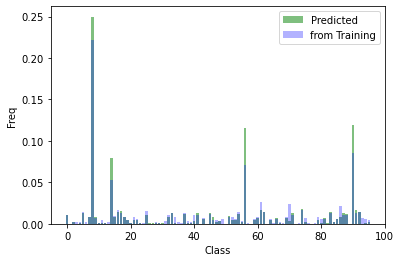

In [134]:
plt.bar(bins[:-1],hist, alpha=0.5, color='green', label='Predicted')
plt.bar(bins[:-1],histTruth, alpha=0.3, color='blue', label='from Training')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.legend()

## Ground Truth

In [176]:
import pandas as pd

In [178]:
truth = pd.read_csv('./test_set_ground_truth.csv')
truth = truth.to_numpy()[:,1]

In [180]:
truth

array([88, 10,  8, ...,  8, 75, 51])

In [181]:
pred_labels

array([39, 10,  8, ..., 51, 90, 14])

In [182]:
accuracy_score(truth, pred_labels)

0.08660060318828092